In [ ]:
!pip install pydicom
 
## Imports
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
 
import tensorflow as tf
import pydicom
from tensorflow import keras
#from medpy.io import load, save
#from medpy.filter import otsu
from pydicom.data import get_testdata_files
from pydicom.filereader import read_dicomdir
from skimage.color import rgb2gray
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
import nibabel as nb
 
## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls '/content/drive/My Drive/COLAB/Colab Notebooks/Data baru'

test  UNet_e150_lr4_b13_1c.h5  UNet_e150_lr4_b13_1c.json


In [ ]:
os.chdir('/content/drive/My Drive/COLAB/Colab Notebooks/Data baru/test')

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=12, image_size=256):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, "boundingbox", id_name) + ".jpg"
        mask_path = os.path.join(self.path, "masks", id_name) +".jpg"
    
        ## Reading Image
        image = np.zeros((self.image_size, self.image_size, 3))
        image_i = cv2.imread(image_path, 1)
        image_i = cv2.resize(image_i, (self.image_size, self.image_size))
        #image_i = np.expand_dims(image_i, axis=-1)
        image = np.maximum(image, image_i)
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        mask_i = cv2.imread(mask_path, 0)
        mask_i = cv2.resize(mask_i, (self.image_size, self.image_size))
        mask_i = np.expand_dims(mask_i, axis=-1)
        mask = np.maximum(mask, mask_i)
                  ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
      
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [ ]:
image_size = 256
train_path = '/content/drive/My Drive/COLAB/Colab Notebooks/Data baru/test'
valid_path = '/content/drive/My Drive/COLAB/Colab Notebooks/Data baru/'
paths_train='/content/drive/My Drive/COLAB/Colab Notebooks/Data baru/test/images/'
paths_valid='/content/drive/My Drive/COLAB/Colab Notebooks/Data baru/test/masks/'
epochs = 150
batch_size = 8

## Training Ids
train_ids = os.listdir(paths_train)
train_ids = [os.path.splitext(x)[0] for x in train_ids]

valid_ids = os.listdir(paths_valid)
valid_ids = [os.path.splitext(x)[0] for x in valid_ids]

## Validation Data Size
print(valid_ids)
print(train_ids)

['P01T1memp+C-IM8', 'P00T1memp+C-IM8', 'P01T2Flair-IM3', 'P01T2Flair-IM4', 'P01T2Flair-IM5', 'P01T2Flair-IM6', 'P01T2Flair-IM10', 'P01T2Flair-IM11', 'P01T2Flair-IM13', 'P01T2Flair-IM12', 'P01T2Flair-IM17', 'P01T2Flair-IM19', 'P01T2Flair-IM20', 'P01T2Flair-IM24', 'P01T2Flair-IM25', 'P01T2Flair-IM26', 'P01T1memp+C-IM9', 'P01T1memp+C-IM10', 'P01T1memp+C-IM11', 'P01T1memp+C-IM12', 'P01T1memp+C-IM13', 'P01T1memp+C-IM21', 'P01T1memp+C-IM23', 'P01T1memp+C-IM24', 'P01T1memp+C-IM25', 'P00T2Flair-IM7', 'P00T2Flair-IM8', 'P00T2Flair-IM9', 'P00T2Flair-IM10', 'P00T2Flair-IM11', 'P00T2Flair-IM19', 'P00T2Flair-IM20', 'P00T2Flair-IM22', 'P00T2Flair-IM23', 'P00T1memp+C-IM7', 'P00T1memp+C-IM9', 'P00T1memp+C-IM21', 'P00T1memp+C-IM20', 'P01T1memp+C-IM4', 'P00T2Flair-IM14', 'P01T1memp+C-IM18', 'P00T2Flair-IM3', 'P01T1memp+C-IM1', 'P01T2Flair-IM2', 'P00T2Flair-IM2', 'P00T2Flair-IM15', 'P01T2Flair-IM16', 'P01T2Flair-IM7', 'P01T2Flair-IM14', 'P00T2Flair-IM17', 'P00T2Flair-IM21', 'P01T1memp+C-IM22', 'P01T2Flai

In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 256, 256, 3) (8, 256, 256, 1)


In [ ]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(x[r], (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    #c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    #c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    #c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [ ]:
def UNet():
    f = [16, 32, 64, 128, 256, 512]
    data_format='channels_last'
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    c5, p5 = down_block(p4, f[4])
    
    bn = bottleneck(p5, f[5])
    
    u1 = up_block(bn, c5, f[4]) #8 -> 16
    u2 = up_block(u1, c4, f[3]) #16 -> 32
    u3 = up_block(u2, c3, f[2]) #32 -> 64
    u4 = up_block(u3, c2, f[1]) #64 -> 128
    u5 = up_block(u4, c1, f[0])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u5)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
adams = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
model = UNet()
model.compile(optimizer=adams , loss="binary_crossentropy", metrics=["acc"])
model.summary()

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, valid_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

In [ ]:
## Save json
model_json=model.to_json()
with open ('/content/drive/My Drive/COLAB/Colab Notebooks/paper baru.json', "w") as json_file:
  json_file.write(model_json)
## Save the Weights
model.save_weights('/content/drive/My Drive/COLAB/Colab Notebooks/paper baru.h5')
## Dataset for prediction
x, y = valid_gen.__getitem__(0)
#print(x)
result = model.predict(x)

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0], (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0], (image_size, image_size)), cmap="gray")

### UNET after training

In [ ]:
image_size = 256
test_path = '/content/drive/My Drive/COLAB/Colab Notebooks/Data baru/test'
names_1= '/content/drive/My Drive/COLAB/Colab Notebooks/Data baru/test/images'
batch_size=53

## Training Ids
test_ids = os.listdir(names_1)
test_ids = [os.path.splitext(x)[0] for x in test_ids]

print(test_ids)
gen = DataGen(test_ids, test_path, batch_size=batch_size, image_size=image_size)
x_1, y_1 = gen.__getitem__(0)

['P00T1memp+C-IM20', 'P00T1memp+C-IM7', 'P00T1memp+C-IM21', 'P00T1memp+C-IM9', 'P00T1memp+C-IM8', 'P00T2Flair-IM10', 'P00T2Flair-IM17', 'P00T2Flair-IM2', 'P00T2Flair-IM7', 'P00T2Flair-IM3', 'P00T2Flair-IM11', 'P00T2Flair-IM19', 'P00T2Flair-IM21', 'P00T2Flair-IM15', 'P00T2Flair-IM23', 'P00T2Flair-IM20', 'P00T2Flair-IM8', 'P00T2Flair-IM22', 'P00T2Flair-IM9', 'P00T2Flair-IM14', 'P01T1memp+C-IM8', 'P01T1memp+C-IM1', 'P01T1memp+C-IM22', 'P01T1memp+C-IM23', 'P01T1memp+C-IM24', 'P01T1memp+C-IM11', 'P01T1memp+C-IM25', 'P01T1memp+C-IM9', 'P01T1memp+C-IM21', 'P01T1memp+C-IM18', 'P01T1memp+C-IM4', 'P01T1memp+C-IM12', 'P01T1memp+C-IM13', 'P01T1memp+C-IM10', 'P01T2Flair-IM11', 'P01T2Flair-IM26', 'P01T2Flair-IM12', 'P01T2Flair-IM16', 'P01T2Flair-IM10', 'P01T2Flair-IM17', 'P01T2Flair-IM13', 'P01T2Flair-IM25', 'P01T2Flair-IM24', 'P01T2Flair-IM20', 'P01T2Flair-IM14', 'P01T2Flair-IM5', 'P01T2Flair-IM18', 'P01T2Flair-IM4', 'P01T2Flair-IM6', 'P01T2Flair-IM7', 'P01T2Flair-IM3', 'P01T2Flair-IM19', 'P01T2Fla

In [ ]:
from keras.models import model_from_json

In [ ]:
json_file = open('/content/drive/My Drive/COLAB/Colab Notebooks/Data baru/UNet_e150_lr4_b13_1c.json','r')
loaded_model_json = json_file.read()
json_file.close()
l_model = model_from_json(loaded_model_json)
l_model.load_weights('/content/drive/My Drive/COLAB/Colab Notebooks/Data baru/UNet_e150_lr4_b13_1c.h5')
adams = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
l_model.compile(optimizer=adams , loss="binary_crossentropy", metrics=["acc"])

In [ ]:
result = l_model.predict(x_1)
score = l_model.evaluate(x_1, y_1)
print(score)


2/2 [==============================] - 3s 1s/step - loss: 0.0336 - acc: 0.9764
[0.03357500210404396, 0.9764456152915955]


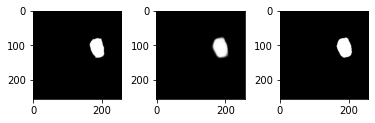

In [ ]:
r, roi = cv2.threshold(result[1],0.5,1,cv2.THRESH_BINARY)
ROIx = np.reshape(roi, (image_size, image_size))
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(np.reshape(y_1[1], (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(result[1], (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(np.reshape(ROIx, (image_size, image_size)), cmap="gray")

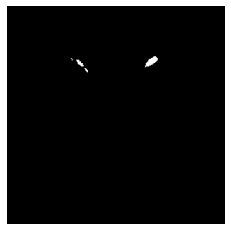

In [ ]:
for im in range(53):
  lala = result[im]
  r, roi = cv2.threshold(lala,0.5,1,cv2.THRESH_BINARY)
  ROIx = np.reshape(roi, (image_size, image_size))
  plt.imshow(np.reshape(ROIx, (image_size, image_size)), cmap="gray")
  plt.axis('off')
  plt.savefig(pathss+test_ids[im]+".jpg", bbox_inches='tight', pad_inches=0)

In [ ]:
from google.colab.patches import cv2_imshow

(-0.5, 255.5, 255.5, -0.5)

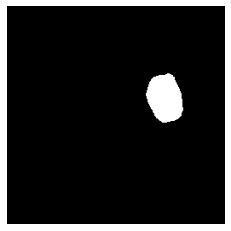

In [ ]:
plt.imshow(np.reshape(ROIx, (image_size, image_size)), cmap="gray")
plt.axis('off')

In [ ]:
pathss = '/content/drive/My Drive/COLAB/Colab Notebooks/Data baru/test/hasil ROI/'
result.shape

(53, 256, 256, 1)

In [ ]:
CCR=np.ones(53)
for im in range(53):
  GT = np.reshape(y_1[im], (image_size, image_size))
  r, roi = cv2.threshold(result[im],0.5,1,cv2.THRESH_BINARY)
  ROIx = np.reshape(roi, (image_size, image_size))
  correct=0;
  for i in range(256):
    for j in range(256):
      if GT[i,j]==ROIx[i,j]:
        correct=correct+1
  CCR[im] = correct/(256*256)
import pandas as pd
df = pd.DataFrame({"image":test_ids,
                   "CCR" : CCR})
df

### make data testing unet after yolo with bounding box

In [ ]:
bb = '/content/drive/My Drive/COLAB/Colab Notebooks/Data baru/test/boundingbox/'
from google.colab.patches import cv2_imshow
im = 52
imagee = '/content/drive/My Drive/COLAB/Colab Notebooks/Data baru/test/images/'
img = cv2.imread(imagee+test_ids[im]+".jpg")
print(test_ids[im])
cv2_imshow(img)

In [ ]:
#Tumor: 33%	(left_x:   72   top_y:   32   width:   34   height:   46)
#Tumor: 91%	(left_x:  139   top_y:   26   width:   55   height:   57)
x = 72;y = 32;w =34;h = 46

#imgg = cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,255),3)
tt = img[y:y+h, x:x+w]
cv2_imshow(tt)
print(tt.shape)
black = np.zeros((256, 256,3), np.uint8)
black[y:y+h, x:x+w]=tt
#x=139; y=26; w=55; h=57
#black[y:y+h, x:x+w]=img[y:y+h, x:x+w]
cv2_imshow(black)
cv2.imwrite(bb+test_ids[im]+".jpg", black)

### training UNET with YOLO

In [ ]:
image_size = 256
test_path = '/content/drive/My Drive/COLAB/Colab Notebooks/Data baru/test'
names_1= '/content/drive/My Drive/COLAB/Colab Notebooks/Data baru/test/boundingbox'
batch_size=53

## Training Ids
test_ids = os.listdir(names_1)
test_ids = [os.path.splitext(x)[0] for x in test_ids]

print(test_ids)
gen = DataGen(test_ids, test_path, batch_size=batch_size, image_size=image_size)
x_2, y_2 = gen.__getitem__(0)

['P00T1memp+C-IM20', 'P00T1memp+C-IM7', 'P00T1memp+C-IM21', 'P00T1memp+C-IM9', 'P00T1memp+C-IM8', 'P00T2Flair-IM10', 'P00T2Flair-IM17', 'P00T2Flair-IM2', 'P00T2Flair-IM7', 'P00T2Flair-IM3', 'P00T2Flair-IM11', 'P00T2Flair-IM19', 'P00T2Flair-IM21', 'P00T2Flair-IM15', 'P00T2Flair-IM23', 'P00T2Flair-IM20', 'P00T2Flair-IM8', 'P00T2Flair-IM22', 'P00T2Flair-IM9', 'P00T2Flair-IM14', 'P01T1memp+C-IM8', 'P01T1memp+C-IM1', 'P01T1memp+C-IM22', 'P01T1memp+C-IM23', 'P01T1memp+C-IM24', 'P01T1memp+C-IM11', 'P01T1memp+C-IM25', 'P01T1memp+C-IM9', 'P01T1memp+C-IM21', 'P01T1memp+C-IM18', 'P01T1memp+C-IM4', 'P01T1memp+C-IM12', 'P01T1memp+C-IM13', 'P01T1memp+C-IM10', 'P01T2Flair-IM11', 'P01T2Flair-IM26', 'P01T2Flair-IM12', 'P01T2Flair-IM16', 'P01T2Flair-IM10', 'P01T2Flair-IM17', 'P01T2Flair-IM13', 'P01T2Flair-IM25', 'P01T2Flair-IM24', 'P01T2Flair-IM20', 'P01T2Flair-IM14', 'P01T2Flair-IM5', 'P01T2Flair-IM18', 'P01T2Flair-IM4', 'P01T2Flair-IM6', 'P01T2Flair-IM7', 'P01T2Flair-IM3', 'P01T2Flair-IM19', 'P01T2Fla

In [ ]:
json_file = open('/content/drive/My Drive/COLAB/Colab Notebooks/Data baru/UNet_e150_lr4_b13_1c.json','r')
loaded_model_json = json_file.read()
json_file.close()
l_model = model_from_json(loaded_model_json)
l_model.load_weights('/content/drive/My Drive/COLAB/Colab Notebooks/Data baru/UNet_e150_lr4_b13_1c.h5')
adams = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
l_model.compile(optimizer=adams , loss="binary_crossentropy", metrics=["acc"])

In [ ]:
result = l_model.predict(x_2)
score = l_model.evaluate(x_2, y_2)
print(score)

2/2 [==============================] - 3s 1s/step - loss: 1.0593 - acc: 0.9578
[1.059262990951538, 0.9577717185020447]


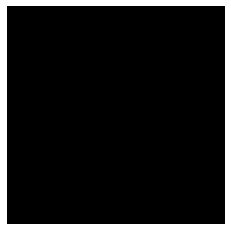

In [ ]:
pathss = '/content/drive/My Drive/COLAB/Colab Notebooks/Data baru/test/ROI boundingbox/'
for im in range(53):
  lala = result[im]
  r, roi = cv2.threshold(lala,0.5,1,cv2.THRESH_BINARY)
  ROIx = np.reshape(roi, (image_size, image_size))
  plt.imshow(np.reshape(ROIx, (image_size, image_size)), cmap="gray")
  plt.axis('off')
  plt.savefig(pathss+test_ids[im]+".jpg", bbox_inches='tight', pad_inches=0)

In [ ]:
CCR=np.ones(53)
for im in range(53):
  GT = np.reshape(y_2[im], (image_size, image_size))
  r, roi = cv2.threshold(result[im],0.5,1,cv2.THRESH_BINARY)
  ROIx = np.reshape(roi, (image_size, image_size))
  correct=0;
  for i in range(256):
    for j in range(256):
      if GT[i,j]==ROIx[i,j]:
        correct=correct+1
  CCR[im] = correct/(256*256)
import pandas as pd
df = pd.DataFrame({"image":test_ids,
                   "CCR" : CCR})
df

,image,CCR
0,P00T1memp+C-IM20,0.991180
1,P00T1memp+C-IM7,0.965805
2,P00T1memp+C-IM21,0.964645
3,P00T1memp+C-IM9,0.978317
4,P00T1memp+C-IM8,0.964020
5,P00T2Flair-IM10,0.953293
6,P00T2Flair-IM17,0.997559
7,P00T2Flair-IM2,0.997559
8,P00T2Flair-IM7,0.972794
9,P00T2Flair-IM3,0.997559
